Analyzing the baroclini tide at VENUS nodes

In [1]:
import datetime
import matplotlib.pylab as plt
import numpy as np

from salishsea_tools import (viz_tools,tidetools, nc_tools, ellipse)
from salishsea_tools.nowcast import (research_VENUS, analyze)

import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style('darkgrid')

In [3]:
path='/data/dlatorne/MEOPAR/SalishSea/nowcast/'
SITES = research_VENUS.SITES['VENUS']
NodalCorr = tidetools.CorrTides

In [4]:
to=datetime.datetime(2014,11,26)
tf=datetime.datetime(2015,4,26)

us = {}; vs = {}; depths= {}; times={}

for site in SITES:
    us[site], vs[site], times[site], depths[site] = ellipse.ellipse_files_nowcast(to, tf, [SITES[site]['i']], 
                                                                                  [SITES[site]['j']], path)

Question - should I exclude the surface layer in the depth averaged currents or not?

Let's try not and see how different the ellipse paramters are.  

In [5]:
def nodal_corrections(tide, tidecorr):
    for const in tide:
        tide[const]['phase'] = (tide[const]['phase'] + tidecorr[const]['uvt'])
        tide[const]['amp'] = tide[const]['amp'] / tidecorr[const]['ft']
        
        tide[const]['amp'], tide[const]['phase'] = tidetools.convention_pha_amp(
                tide[const]['amp'], tide[const]['phase'])
    return tide

In [6]:
nconst=8
barotropic_ellipse ={}
u_rot ={}; v_rot={}
u_rot_baro={}; v_rot_baro={}
u_tide_baro={}; v_tide_baro={}
for site in SITES:
    u_rot[site],v_rot[site] = ellipse.prepare_vel(us[site], vs[site])
    
    #ellipses and tide fits for u/ rotates
    u_rot_baro[site],v_rot_baro[site] = ellipse.prepare_vel(us[site], vs[site], depav=True, depth=depths[site])
    u_tide_baro[site] = tidetools.fittit(u_rot_baro[site],times[site], nconst )
    v_tide_baro[site] = tidetools.fittit(v_rot_baro[site],times[site], nconst )
    #nodal corrections
    u_tide_baro[site] = nodal_corrections(u_tide_baro[site], NodalCorr)
    v_tide_baro[site] = nodal_corrections(v_tide_baro[site], NodalCorr)
    
    barotropic_ellipse[site] = ellipse.get_params(u_rot_baro[site], v_rot_baro[site], times[site], nconst)

Construct barotopic tidal curents

In [7]:
u_bt = {}
v_bt = {}

for site in SITES:
    u_bt[site] = np.zeros(len(times[site]))
    v_bt[site] = np.zeros(len(times[site]))
    for const in u_tide_baro[site]:
        ampU = u_tide_baro[site][const]['amp'] * NodalCorr[const]['ft']
        phaU = u_tide_baro[site][const]['phase'] - NodalCorr[const]['uvt']
        u_bt[site] = u_bt[site] + ampU*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaU)*np.pi/180)
        
        ampV = v_tide_baro[site][const]['amp'] * NodalCorr[const]['ft']
        phaV = v_tide_baro[site][const]['phase'] - NodalCorr[const]['uvt']
        v_bt[site] = v_bt[site] + ampV*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaV)*np.pi/180)
        

Check that phase, etc is reasonable by plotting

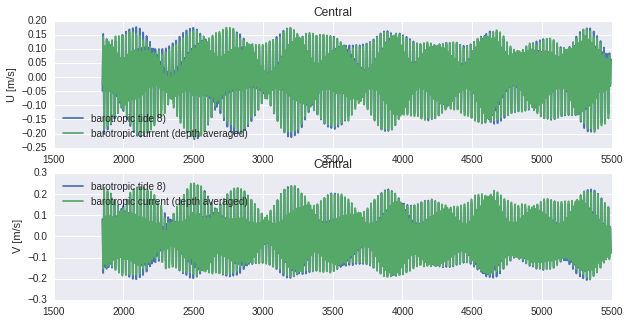

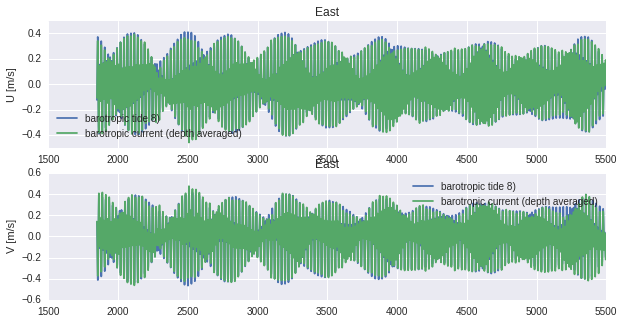

In [8]:
for site in ['Central', 'East']:
    fig,axs=plt.subplots(2,1, figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bt[site][0,:],label='barotropic tide 8)')
    ax.plot(times[site], u_rot_baro[site][:,0,0] - np.mean(u_rot_baro[site]),label = 'barotropic current (depth averaged)')
    ax.legend(loc=0)
    ax.set_ylabel('U [m/s]')
    ax.set_title(site)
    ax=axs[1]
    ax.plot(times[site], v_bt[site][0,:],label='barotropic tide 8)')
    ax.plot(times[site], v_rot_baro[site][:,0,0] - np.mean(v_rot_baro[site]),label = 'barotropic current (depth averaged)')
    ax.legend(loc=0)
    ax.set_ylabel('V [m/s]')
    ax.set_title(site)

Looks like tidal predictions reproduce the depth averaged currents reasonably well.

#Baroclinic Tide

In [24]:
u_bc_curr= {}
v_bc_curr = {}

for site in SITES:
    u_bc_curr[site] = u_rot[site][:,:,0,0] - u_bt[site].T
    v_bc_curr[site] = v_rot[site][:,:,0,0] - v_bt[site].T

In [44]:
u_bc_tide={}
v_bc_tide={}
baroclinic_tide={}

for site in SITES:
    u_bc_tide[site] = tidetools.fittit(u_bc_curr[site],times[site], nconst )
    v_bc_tide[site] = tidetools.fittit(v_bc_curr[site],times[site], nconst )
    #nodal corrections - is that applicable for baroclinic?
    #u_bc_tide[site] = nodal_corrections(u_bc_tide[site], NodalCorr)
    #v_bc_tide[site] = nodal_corrections(v_bc_tide[site], NodalCorr)
    
    baroclinic_tide[site] = ellipse.get_params(u_bc_curr[site], v_bc_curr[site], times[site], nconst)

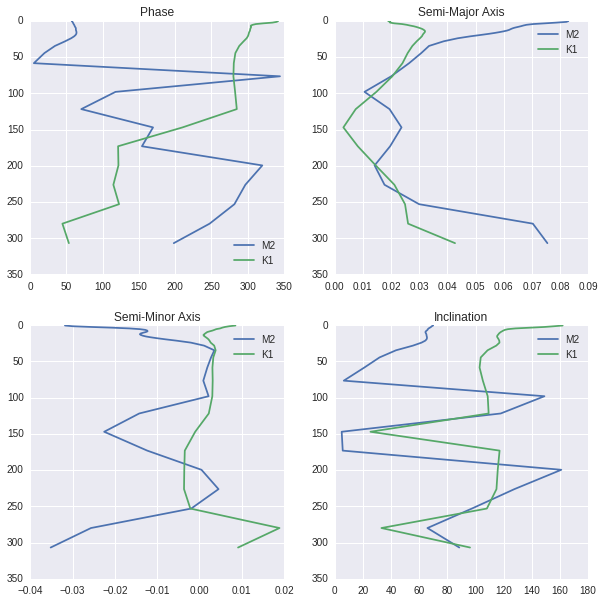

In [45]:
site = 'Central'

fig, axs = plt.subplots(2,2,figsize=(10,10))
for const in ['M2', 'K1']:
    for ax, param in zip(axs.flatten(), baroclinic_tide[site][const]):
        ax.plot( baroclinic_tide[site][const][param], depths[site], label =const)
        ax.set_title(param)
        ax.set_ylim([350,0])
        ax.legend(loc=0)

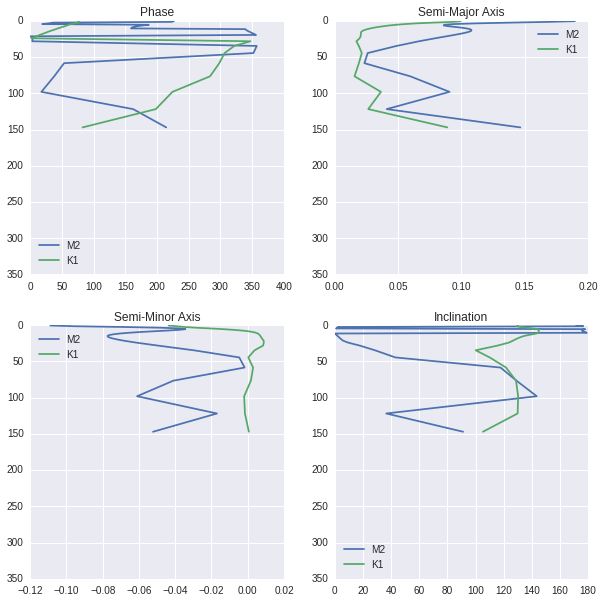

In [46]:
site = 'East'

fig, axs = plt.subplots(2,2,figsize=(10,10))
for const in ['M2', 'K1']:
    for ax, param in zip(axs.flatten(), baroclinic_tide[site][const]):
        ax.plot( baroclinic_tide[site][const][param], depths[site], label =const)
        ax.set_title(param)
        ax.set_ylim([350,0])
        ax.legend(loc=0)

In [47]:
for site in SITES:
    for const in ['M2','K1']:
        print site, const, baroclinic_tide[site][const]['Semi-Major Axis'][0]

East M2 0.189396459164
East K1 0.0994395947343
Central M2 0.0829116477874
Central K1 0.0190374642557
ddl M2 0.164538946102
ddl K1 0.0943125221653


I don't think I trust the inlcination and phase

In [48]:
for site in SITES:
    for const in ['M2','K1']:
        print site, const, baroclinic_tide[site][const]['Phase'][0]

East M2 226.584060567
East K1 75.2701999921
Central M2 57.258189322
Central K1 341.918553567
ddl M2 254.966071312
ddl K1 98.9733225342


Create baroclinic tidal prediction

In [54]:
u_bc={}
v_bc={}
for site in SITES:
    u_bc[site] = np.zeros((len(times[site]), 40))
    v_bc[site] = np.zeros((len(times[site]),40))
    for const in u_tide_baro[site]:
        ampU = u_bc_tide[site][const]['amp'] 
        phaU = u_bc_tide[site][const]['phase']
        
        ampV = v_bc_tide[site][const]['amp'] 
        phaV = v_bc_tide[site][const]['phase'] 
        for k in np.arange(u_bc[site].shape[-1]):
            u_bc[site][:,k] = u_bc[site][:,k] + ampU[k]*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaU[k])*np.pi/180)
            v_bc[site][:,k] = v_bc[site][:,k] + ampV[k]*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaV[k])*np.pi/180)
        

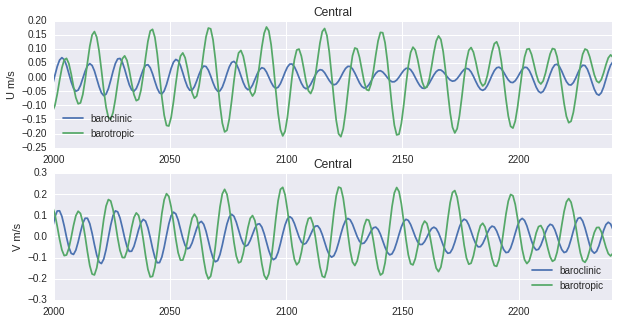

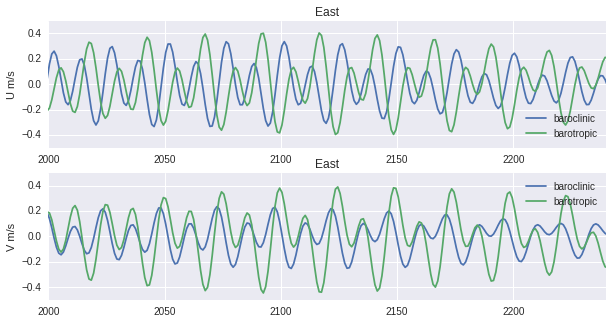

In [66]:
numdays=10
for site in ['Central','East']:
    fig,axs=plt.subplots(2,1,figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bc[site][:,0],label='baroclinic')
    ax.plot(times[site], u_bt[site][0,:],label='barotropic')
    ax.set_xlim([2000,2000+24*numdays])
    ax.legend(loc=0)
    ax.set_ylabel('U m/s')
    ax.set_title(site)
    ax=axs[1]
    ax.plot(times[site], v_bc[site][:,0],label='baroclinic')
    ax.plot(times[site], v_bt[site][0,:],label='barotropic')
    ax.set_xlim([2000,2000+24*numdays])
    ax.legend(loc=0)
    ax.set_ylabel('V m/s')
    ax.set_title(site)